In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import plotly.express as px

# modelling
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples, davies_bouldin_score
from sklearn.decomposition import PCA

# import a bunch of clustering models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

In [3]:
df = pd.read_csv('Data/uswtdb_v5_0_20220427_rename.csv',
                 index_col=False)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_7496/2769116822.py:1: DtypeWarning: Columns (1,2,3,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Use this dataset/uswtdb_v5_0_20220427_rename.csv',


In [4]:
df.shape

(71784, 124)

In [5]:
df.head()

,Plant Id,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,NAICS Code,EIA Sector Number,Sector Name,Reported\nPrime Mover,Reported\nFuel Type Code,AER\nFuel Type Code,Balancing\nAuthority Code,Respondent\nFrequency,Physical\nUnit Label,Quantity\nJanuary,Quantity\nFebruary,Quantity\nMarch,Quantity\nApril,Quantity\nMay,Quantity\nJune,Quantity\nJuly,Quantity\nAugust,Quantity\nSeptember,Quantity\nOctober,Quantity\nNovember,Quantity\nDecember,Elec_Quantity\nJanuary,Elec_Quantity\nFebruary,Elec_Quantity\nMarch,Elec_Quantity\nApril,Elec_Quantity\nMay,Elec_Quantity\nJune,Elec_Quantity\nJuly,Elec_Quantity\nAugust,Elec_Quantity\nSeptember,Elec_Quantity\nOctober,Elec_Quantity\nNovember,Elec_Quantity\nDecember,MMBtuPer_Unit\nJanuary,MMBtuPer_Unit\nFebruary,MMBtuPer_Unit\nMarch,MMBtuPer_Unit\nApril,MMBtuPer_Unit\nMay,MMBtuPer_Unit\nJune,MMBtuPer_Unit\nJuly,MMBtuPer_Unit\nAugust,MMBtuPer_Unit\nSeptember,MMBtuPer_Unit\nOctober,MMBtuPer_Unit\nNovember,MMBtuPer_Unit\nDecember,Tot_MMBtu\nJanuary,Tot_MMBtu\nFebruary,Tot_MMBtu\nMarch,Tot_MMBtu\nApril,Tot_MMBtu\nMay,Tot_MMBtu\nJune,Tot_MMBtu\nJuly,Tot_MMBtu\nAugust,Tot_MMBtu\nSeptember,Tot_MMBtu\nOctober,Tot_MMBtu\nNovember,Tot_MMBtu\nDecember,Elec_MMBtu\nJanuary,Elec_MMBtu\nFebruary,Elec_MMBtu\nMarch,Elec_MMBtu\nApril,Elec_MMBtu\nMay,Elec_MMBtu\nJune,Elec_MMBtu\nJuly,Elec_MMBtu\nAugust,Elec_MMBtu\nSeptember,Elec_MMBtu\nOctober,Elec_MMBtu\nNovember,Elec_MMBtu\nDecember,Netgen\nJanuary,Netgen\nFebruary,Netgen\nMarch,Netgen\nApril,Netgen\nMay,Netgen\nJune,Netgen\nJuly,Netgen\nAugust,Netgen\nSeptember,Netgen\nOctober,Netgen\nNovember,Netgen\nDecember,Total Fuel Consumption\nQuantity,Electric Fuel Consumption\nQuantity,Total Fuel Consumption\nMMBtu,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),YEAR,case_id,faa_digital_obstacle_id,faa_obstruction_evaluation_id,usgs_id,eia_id,state,county,state_county_id,project_name,operational_year,project_turbine_num,cumulative_capacity (MW),manufacturer,model_name,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),retrofit (y/n),retrofit_year,attribute_confidence_level (1/2/3),location_confidence_level (1/2/3),location_verification_date,image_source,xlong,ylat
0,1.0,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560.0,AK,PACN,NaN,NaN,22.0,1.0,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,78,97,77,91,94,111,113,115,117,66,122,103,78,97,77,91,94,111,113,115,117,66,122,11.609,8.836,11.011,8.745,10.329,10.673,12.572,12.738,13.051,13.182,7.49,13.764,0.0,0.0,1184.0,1184.0,134.0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90.0,N,.,Snake River,Nome Joint Utility Systems,13642.0,AK,PACN,NaN,NaN,22.0,1.0,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,184.495,140.449,175.033,139.011,164.189,169.653,199.846,202.478,207.46,209.538,119.062,218.786,0.0,0.0,18837.0,18837.0,2130.0,2021.0,3032513.0,02-020068,2009-WTW-1520-OE,1900.0,90.0,AK,Nome Census Area,2180.0,Nome,2008.0,18.0,0.9,Entegrity,EW50,50.0,31.1,15.0,176.71,38.6,0.0,NaN,3.0,3.0,9/30/2019,Digital Globe,-165.426483,64.571999
2,90.0,N,.,Snake River,Nome Joint Utility Systems,13642.0,AK,PACN,NaN,NaN,22.0,1.0,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,184.495,140.449,175.033,139.011,164.189,169.653,199.846,202.478,207.46,209.538,119.062,218.786,0.0,0.0,18837.0,18837.0,2130.0,2021.0,3032511.0,02-020066,2009-WTW-1518-OE,1898.0,90.0,AK,Nome Census Area,2180.0,Nome,2008.0,18.0,0.9,Entegrit

## Missing Model Specs 

In [6]:
df.isnull().sum()

Plant Id                                7794
Combined Heat And\nPower Plant          7794
Nuclear Unit Id                         7794
Plant Name                              7794
Operator Name                           7794
Operator Id                             7794
Plant State                             7794
Census Region                           7794
NERC Region                             7973
Reserved                               71784
NAICS Code                              7794
EIA Sector Number                       7794
Sector Name                             7794
Reported\nPrime Mover                   7794
Reported\nFuel Type Code                7794
AER\nFuel Type Code                     7794
Balancing\nAuthority Code               7965
Respondent\nFrequency                   7796
Physical\nUnit Label                   71784
Quantity\nJanuary                       7794
Quantity\nFebruary                      7794
Quantity\nMarch                         7794
Quantity\n

In [7]:
unique_plants = df['eia_id'].nunique()
print(f'we have {unique_plants} unique plants before removing null values')

we have 1207 unique plants before removing null values


In [8]:
unique_projects = df['project_name'].nunique()
print(f'we have {unique_projects} unique projects before removing null values')

we have 1726 unique projects before removing null values


### Missing EIA_ID

In [9]:
missing_values = len(df[df.eia_id.isnull()])
print(missing_values)

6207


In [10]:
unique_turbines = len(df)
print(f'we are dropping {(missing_values/unique_turbines)*100:.2f}% of the data')
df = df[~df.eia_id.isnull()]
unique_turbines = len(df)
print(f'we have {unique_turbines} unique projects after removing null values')

we are dropping 8.65% of the data
we have 65577 unique projects after removing null values


### Turbine Capacity

In [11]:
missing_values=len(df[df['turbine_capacity (KW)'].isnull()])
print(missing_values)

929


In [12]:
print(f'we are dropping {(missing_values/unique_turbines)*100:.2f}% of the data')
df = df[~df['turbine_capacity (KW)'].isnull()]
unique_turbines = len(df)
print(f'we have {unique_turbines} unique projects after removing null values')

we are dropping 1.42% of the data
we have 64648 unique projects after removing null values


## Model

In [13]:
# are the columns the same?
a = df['Elec Fuel Consumption\nMMBtu'] == df['Total Fuel Consumption\nMMBtu']
# assert all of the a.value_counts() are true
assert all(a.value_counts())==True, 'The columns are not the same'

In [14]:
df.isnull().sum()

Plant Id                                1531
Combined Heat And\nPower Plant          1531
Nuclear Unit Id                         1531
Plant Name                              1531
Operator Name                           1531
Operator Id                             1531
Plant State                             1531
Census Region                           1531
NERC Region                             1701
Reserved                               64648
NAICS Code                              1531
EIA Sector Number                       1531
Sector Name                             1531
Reported\nPrime Mover                   1531
Reported\nFuel Type Code                1531
AER\nFuel Type Code                     1531
Balancing\nAuthority Code               1701
Respondent\nFrequency                   1531
Physical\nUnit Label                   64648
Quantity\nJanuary                       1531
Quantity\nFebruary                      1531
Quantity\nMarch                         1531
Quantity\n

In [15]:
features = ['eia_id',
            'turbine_capacity (KW)',
            'hub_height (m)',
            'rotor_diameter (m)',
            'rotor_swept area (m2)',
            'max_height (m)',
            'xlong','ylat']

In [16]:
# group by turbine_capacity (KW) and project_name
model_df = df[features]

In [17]:
model_df.shape

(64648, 8)

In [18]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64648 entries, 1 to 71783
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   eia_id                 64648 non-null  float64
 1   turbine_capacity (KW)  64648 non-null  float64
 2   hub_height (m)         64008 non-null  float64
 3   rotor_diameter (m)     64246 non-null  float64
 4   rotor_swept area (m2)  64246 non-null  float64
 5   max_height (m)         64007 non-null  float64
 6   xlong                  64648 non-null  float64
 7   ylat                   64648 non-null  float64
dtypes: float64(8)
memory usage: 4.4 MB


## Numerical Features

In [19]:
model_df.describe()

,eia_id,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat
count,64648.000000,64648.000000,64008.000000,64246.000000,64246.000000,64007.000000,64648.000000,64648.000000
mean,58133.513055,1974.941576,81.373633,96.135789,7665.433845,129.604739,-99.554930,38.567768
std,5317.846899,702.519645,11.388520,22.757731,3271.550756,21.154158,10.802928,5.471205
min,90.000000,50.000000,22.800000,15.000000,176.710000,30.400000,-170.498276,17.970871
25%,56776.000000,1500.000000,80.000000,82.000000,5281.020000,121.000000,-102.478103,34.205523
50%,57793.500000,2000.000000,80.000000,100.000000,7853.980000,130.100000,-99.069828,39.313633
75%,60366.000000,2300.000000,87.500000,112.000000,9852.030000,145.100000,-94.913513,42.991355
max,65270.000000,6000.000000,131.000000,155.000000,18869.190000,199.600000,-65.610001,66.839905


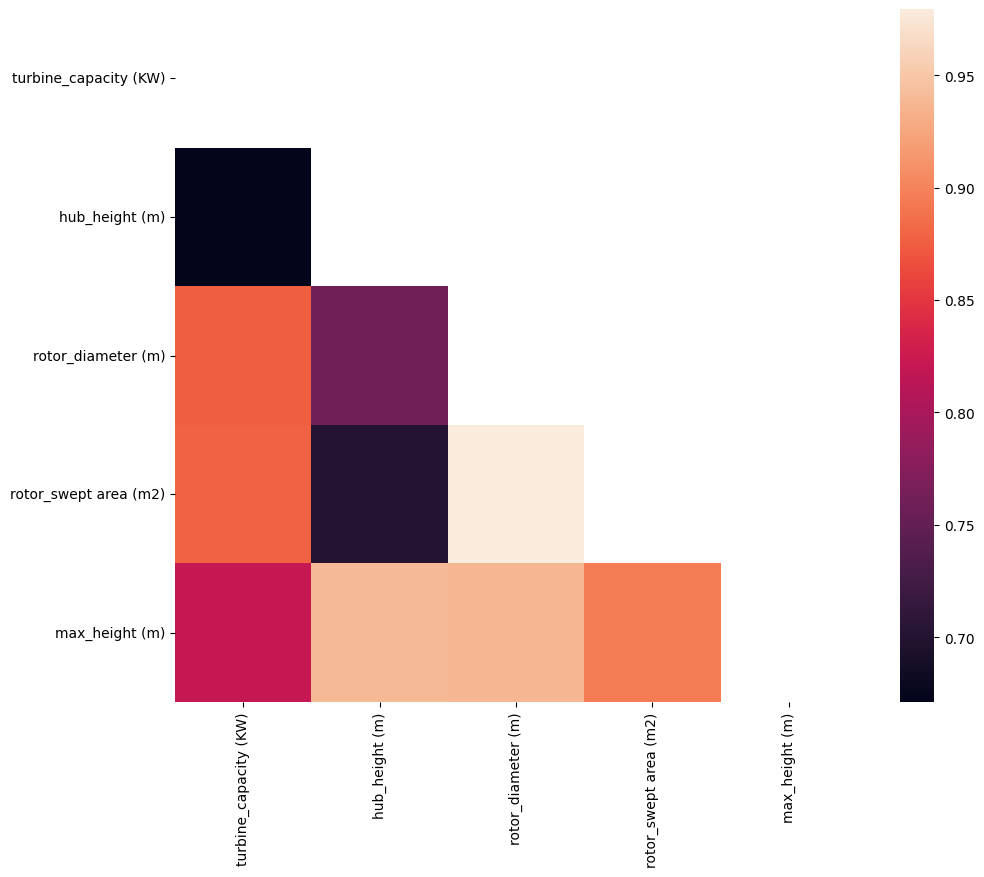

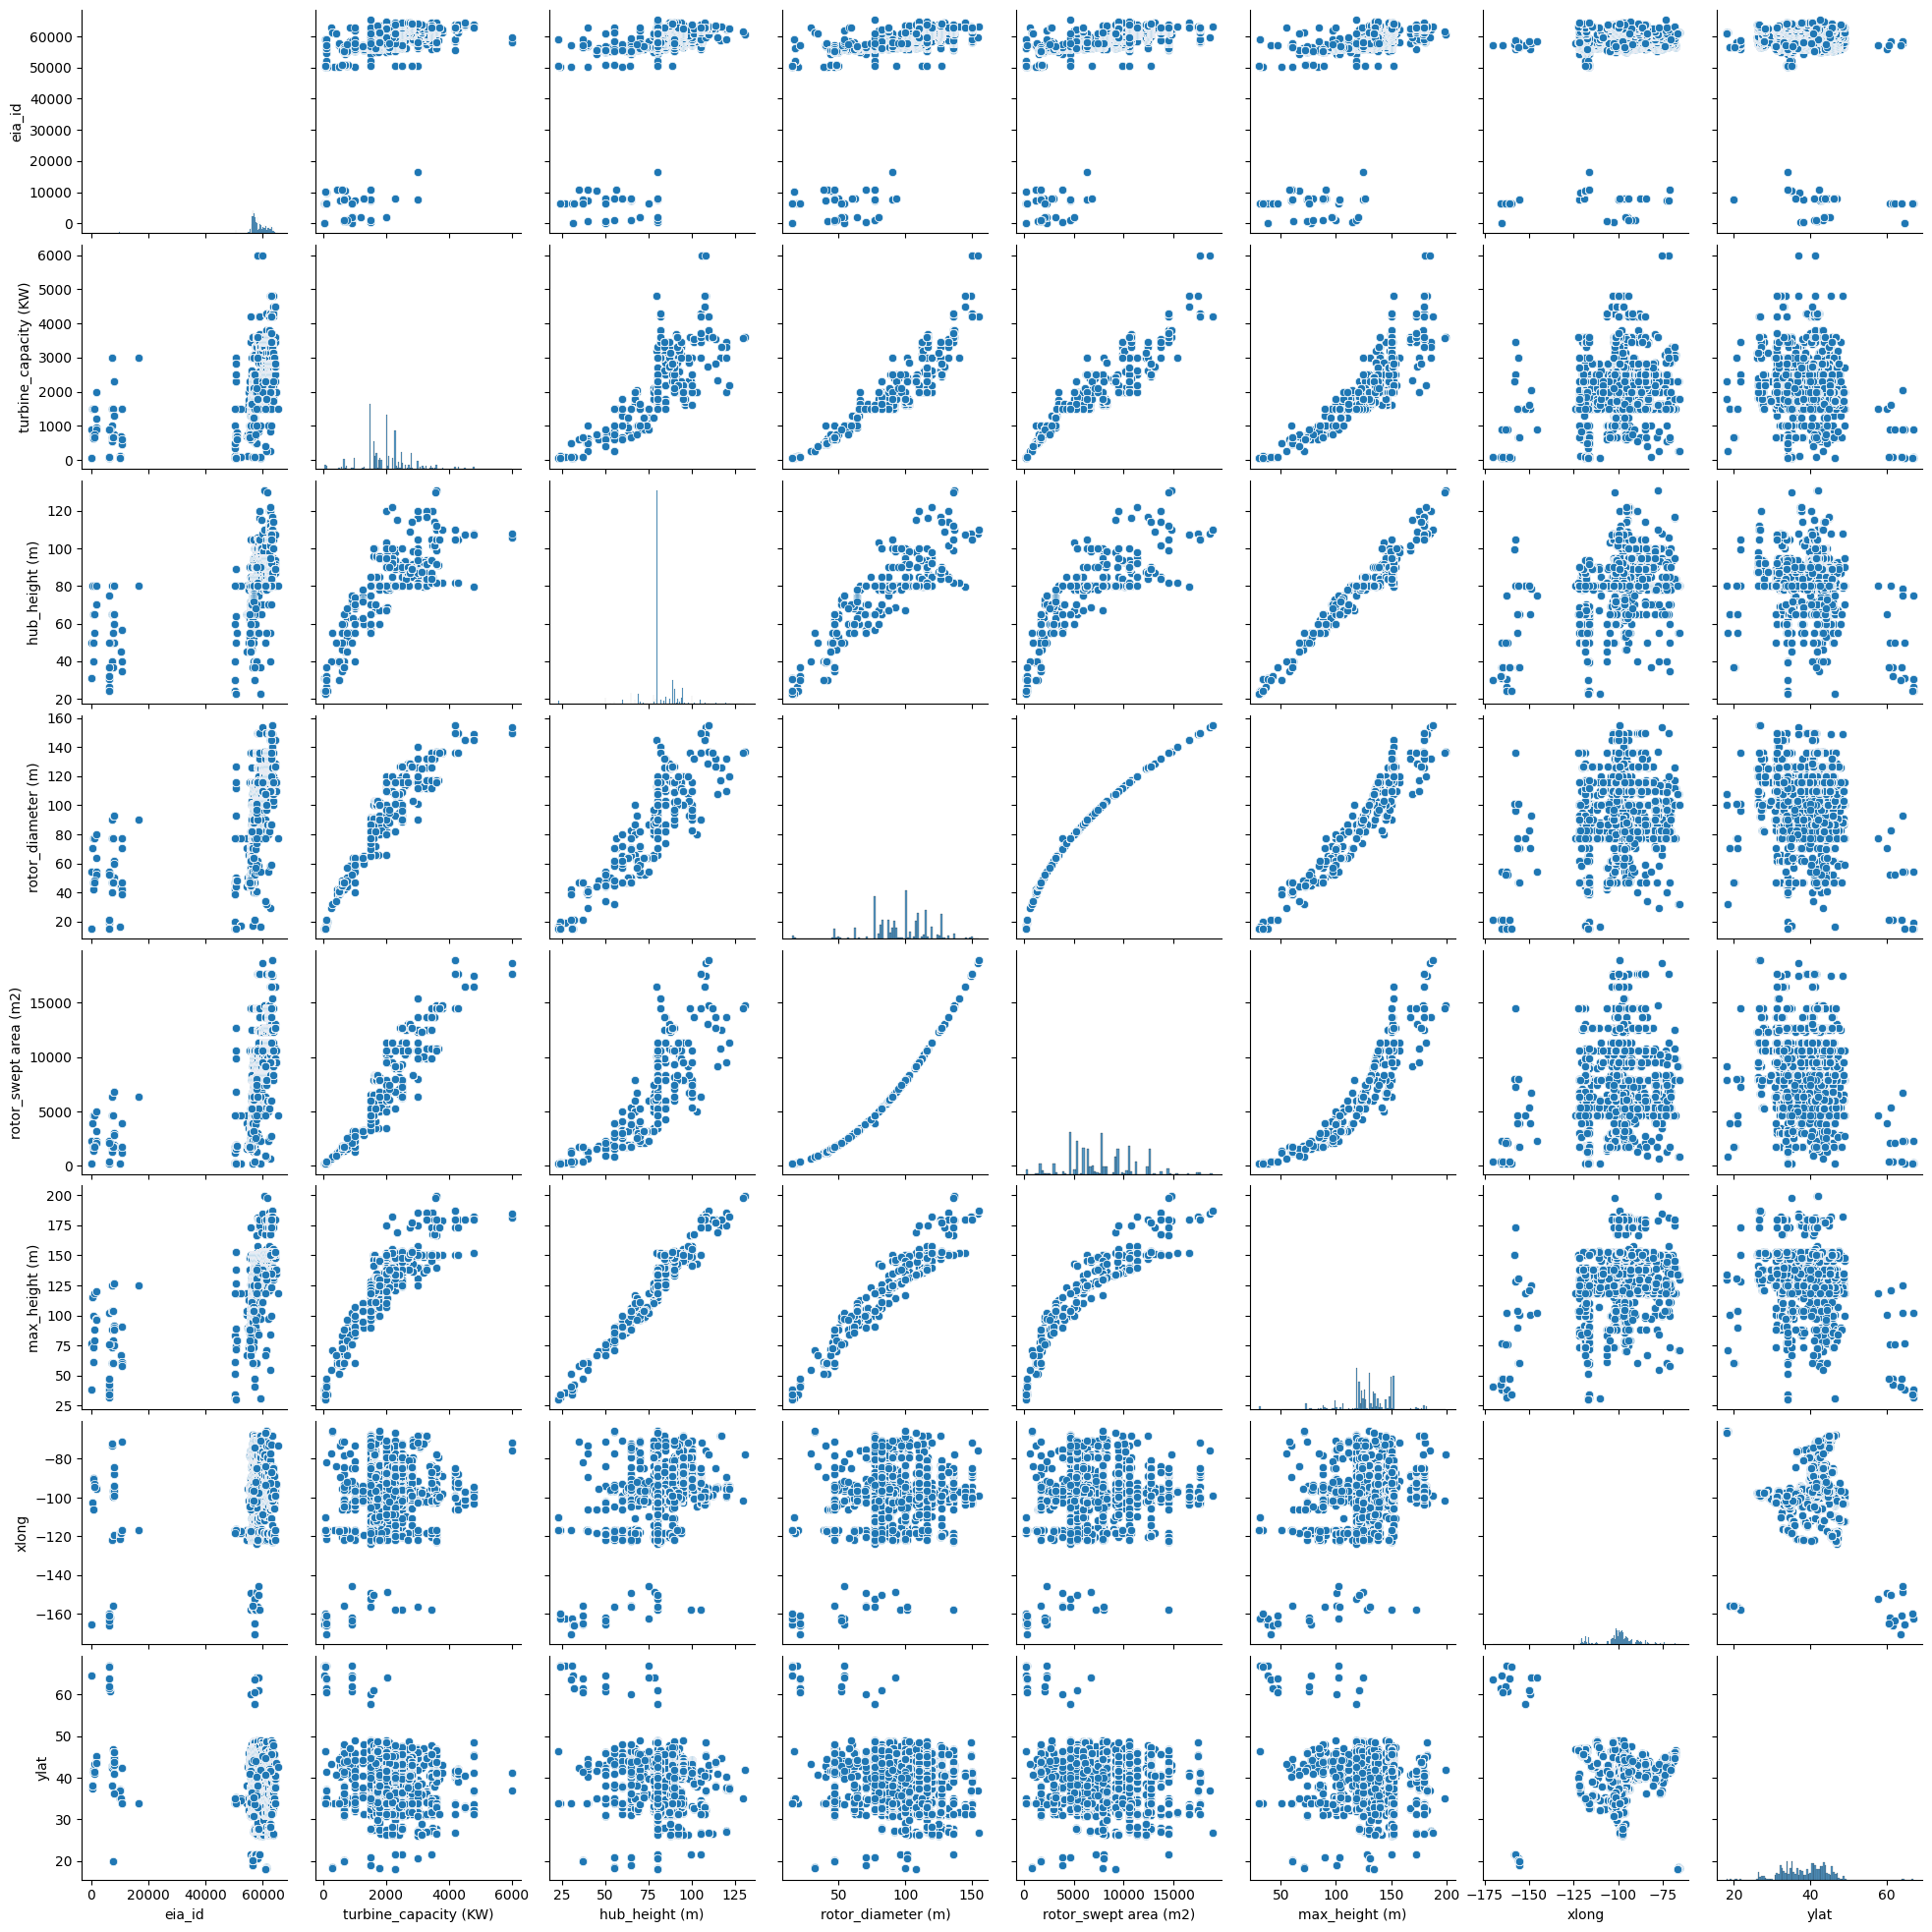

In [20]:
# plot a correlation matrix
import seaborn as sns
# remove xlong and ylat
corr_df = model_df.drop(['xlong','ylat','eia_id'], axis=1)
corr = corr_df.corr(numeric_only=True)

# show only half the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask)

# plot a pairplot
sns.pairplot(model_df)

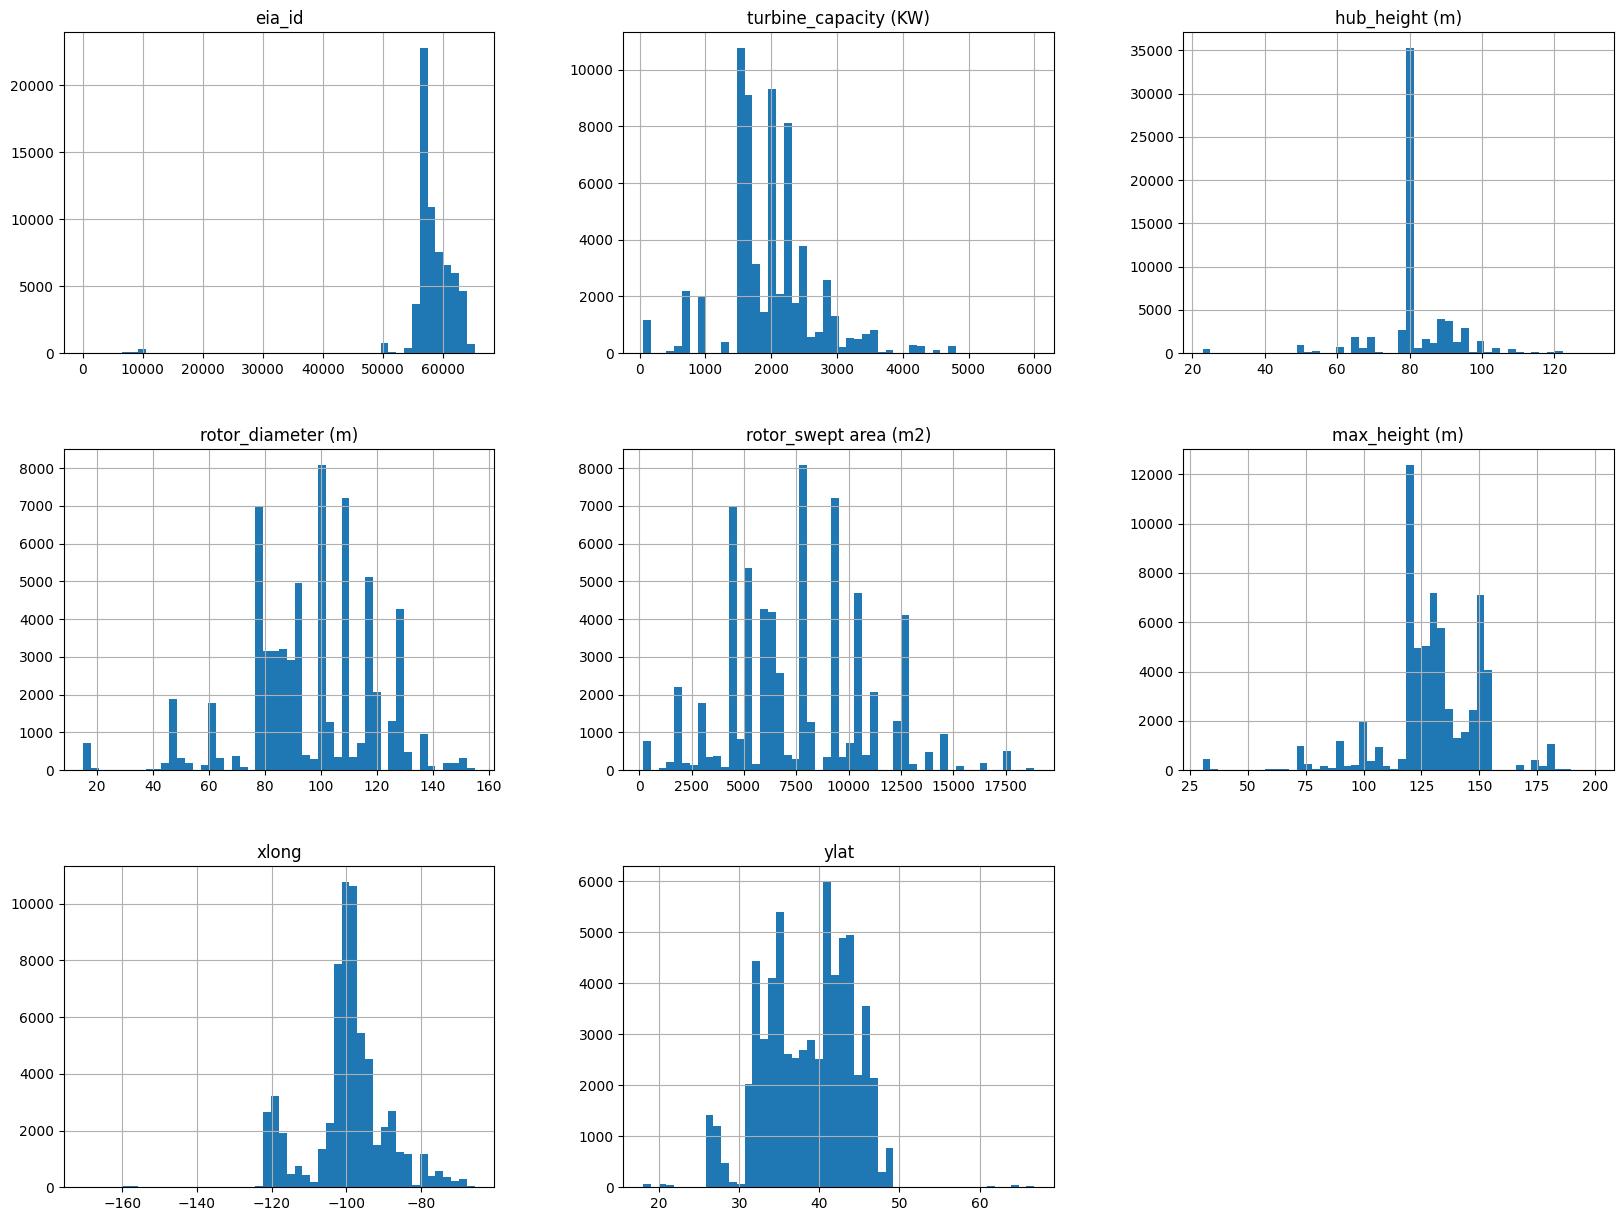

In [21]:
# plot histogram for each numerical feature
model_df.hist(bins=50, figsize=(20,15))
plt.show()

## 860 file

In [22]:
# read from second row
df_86 = pd.read_excel('Data/eia860_num_wt_Y2021.xlsx', skiprows=1)

In [23]:
df_86.head()

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,Sector Name,Sector,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Operating Month,Operating Year,Number of Turbines,Predominant Turbine Manufacturer,Predominant Turbine Model Number,Design Wind Speed (mph),Wind Quality Class,Turbine Hub Height (Feet)
0,63560,"TDX Sand Point Generating, LLC",1,Sand Point,AK,Aleutians East,WT1,OS,Onshore Wind Turbine,WT,Electric Utility,1,0.5,0.1,0.1,10,2011,1,Vestas,V39-500,19.0,2,155.0
1,63560,"TDX Sand Point Generating, LLC",1,Sand Point,AK,Aleutians East,WT2,OA,Onshore Wind Turbine,WT,Electric Utility,1,0.5,0.3,0.3,10,2011,1,Vestas,V39-500,19.0,2,155.0
2,13642,Nome Joint Utility Systems,90,Snake River,AK,Nome,EWT 1,OP,Onshore Wind Turbine,WT,Electric Utility,1,0.9,0.9,0.9,7,2013,1,EWT,DW54-900,20.0,2,164.0
3,13642,Nome Joint Utility Systems,90,Snake River,AK,Nome,EWT 2,OP,Onshore Wind Turbine,WT,Electric Utility,1,0.9,0.9,0.9,7,2013,1,EWT,DW54-900,20.0,2,164.0
4,10633,City of Lamar - (CO),508,Lamar Plant,CO,Prowers,T1-T3,OP,Onshore Wind Turbine,WT,Electric Utility,1,4.5,4.0,4.0,2,2004,3,GE,1.5 XLE,19.0,2,262.4


In [24]:
# get nameplate capacity by plant Code
df_86 = df_86[['Plant Code', 'Nameplate Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)','Number of Turbines','Sector Name','Utility Name']]

In [25]:
df_86.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Plant Code               1485 non-null   int64  
 1   Nameplate Capacity (MW)  1485 non-null   float64
 2   Summer Capacity (MW)     1485 non-null   float64
 3   Winter Capacity (MW)     1485 non-null   float64
 4   Number of Turbines       1485 non-null   int64  
 5   Sector Name              1485 non-null   object 
 6   Utility Name             1485 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 81.3+ KB


In [26]:
df_86.describe()

,Plant Code,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,56441.230976,89.872121,89.396229,89.337104,46.535354
std,10682.745044,93.603497,93.109783,92.981993,48.851261
min,1.000000,0.100000,0.100000,0.100000,1.000000
25%,56636.000000,7.900000,7.500000,7.500000,5.000000
50%,57748.000000,62.500000,62.400000,62.400000,34.000000
75%,60049.000000,150.000000,150.000000,150.000000,72.000000
max,65484.000000,600.000000,582.300000,582.300000,460.000000


In [27]:
# consolidate by Plant Code but include Sector Name and Utility Name
df_860 = df_86.groupby(['Plant Code','Sector Name','Utility Name']).sum().reset_index()

In [28]:
# reset index of df_860 but keep the column
df_860.head()

,Plant Code,Sector Name,Utility Name,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines
0,1,Electric Utility,"TDX Sand Point Generating, LLC",1.0,0.4,0.4,2
1,90,Electric Utility,Nome Joint Utility Systems,1.8,1.8,1.8,2
2,508,Electric Utility,City of Lamar - (CO),6.0,5.5,5.5,4
3,692,IPP Non-CHP,SRIV Partnership LLC,6.2,6.2,6.2,9
4,944,Electric Utility,City of Geneseo - (IL),3.0,3.0,3.0,2


## 923

In [29]:
df_92 = pd.read_excel('Data/EIA923_Schedules_2_3_4_5_M_12_2021_Final_Revision.xlsx',skiprows=5)

In [30]:
df_92.head()

,Plant Id,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,NAICS Code,EIA Sector Number,Sector Name,Reported\nPrime Mover,Reported\nFuel Type Code,AER\nFuel Type Code,Balancing\nAuthority Code,Respondent\nFrequency,Physical\nUnit Label,Quantity\nJanuary,Quantity\nFebruary,Quantity\nMarch,Quantity\nApril,Quantity\nMay,Quantity\nJune,Quantity\nJuly,Quantity\nAugust,Quantity\nSeptember,Quantity\nOctober,Quantity\nNovember,Quantity\nDecember,Elec_Quantity\nJanuary,Elec_Quantity\nFebruary,Elec_Quantity\nMarch,Elec_Quantity\nApril,Elec_Quantity\nMay,Elec_Quantity\nJune,Elec_Quantity\nJuly,Elec_Quantity\nAugust,Elec_Quantity\nSeptember,Elec_Quantity\nOctober,Elec_Quantity\nNovember,Elec_Quantity\nDecember,MMBtuPer_Unit\nJanuary,MMBtuPer_Unit\nFebruary,MMBtuPer_Unit\nMarch,MMBtuPer_Unit\nApril,MMBtuPer_Unit\nMay,MMBtuPer_Unit\nJune,MMBtuPer_Unit\nJuly,MMBtuPer_Unit\nAugust,MMBtuPer_Unit\nSeptember,MMBtuPer_Unit\nOctober,MMBtuPer_Unit\nNovember,MMBtuPer_Unit\nDecember,Tot_MMBtu\nJanuary,Tot_MMBtu\nFebruary,Tot_MMBtu\nMarch,Tot_MMBtu\nApril,Tot_MMBtu\nMay,Tot_MMBtu\nJune,Tot_MMBtu\nJuly,Tot_MMBtu\nAugust,Tot_MMBtu\nSeptember,Tot_MMBtu\nOctober,Tot_MMBtu\nNovember,Tot_MMBtu\nDecember,Elec_MMBtu\nJanuary,Elec_MMBtu\nFebruary,Elec_MMBtu\nMarch,Elec_MMBtu\nApril,Elec_MMBtu\nMay,Elec_MMBtu\nJune,Elec_MMBtu\nJuly,Elec_MMBtu\nAugust,Elec_MMBtu\nSeptember,Elec_MMBtu\nOctober,Elec_MMBtu\nNovember,Elec_MMBtu\nDecember,Netgen\nJanuary,Netgen\nFebruary,Netgen\nMarch,Netgen\nApril,Netgen\nMay,Netgen\nJune,Netgen\nJuly,Netgen\nAugust,Netgen\nSeptember,Netgen\nOctober,Netgen\nNovember,Netgen\nDecember,Total Fuel Consumption\nQuantity,Electric Fuel Consumption\nQuantity,Total Fuel Consumption\nMMBtu,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),YEAR
0,1,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560,AK,PACN,NaN,NaN,22,1,Electric Utility,IC,DFO,DFO,NaN,A,barrels,466,514,556,535,277,372,363,524,679,674,526,585,466,514,556,535,277,372,363,524,679,674,526,585,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,2724,3005,3250,3128,1619,2175,2122,3063,3969,3940,3075,3420,2724,3005,3250,3128,1619,2175,2122,3063,3969,3940,3075,3420,208.841,231.25,250.099,240.409,124.504,167.13,163.329,235.54,305.071,303.095,236.655,263.077,6071,6071,35490,35490,2729.0,2021
1,1,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560,AK,PACN,NaN,NaN,22,1,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,78,97,77,91,94,111,113,115,117,66,122,103,78,97,77,91,94,111,113,115,117,66,122,11.609,8.836,11.011,8.745,10.329,10.673,12.572,12.738,13.051,13.182,7.49,13.764,0,0,1184,1184,134.0,2021
2,2,N,.,Bankhead Dam,Alabama Power Co,195,AL,ESC,SERC,NaN,22,1,Electric Utility,HY,WAT,HYC,SOCO,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193267,160812,154227,136040,168541,181467,161573,152459,125050,128322,150396,193250,193267,160812,154227,136040,168541,181467,161573,152459,125050,128322,150396,193250,21852.91,18183.22,17438.642,15382.198,19057.047,20518.616,18269.278,17238.672,14139.512,14509.501,17005.425,21850.979,0,0,1905404,1905404,215446.0,2021
3,3,N,.,Barry,Alabama Power Co,195,AL,ESC,SERC,NaN,22,1,Electric Utility,CA,NG,NG,SOCO,M,mcf,37837,24972,22230,48459,63513,87775,59474,62849,42565,75889,25392,55729,37837,24972,22230,48459,63513,87775,59474,62849,42565,75889,25392,55729,1.015,1.015,1.015,1.015,1.015,1.013,1.015,1.013,1.016,1.016,1.013,1.012,38405,25347,22563,49186,64466,88916,60366,63666,43246,77103,25722,56398,38405,25347,22563,49186,64466,88916,60366,63666,43246,77103,25722,56398,267855,211532,151640,208134,246122,253273,262176,262090,168852,218962,239159,215057,606684,606684,615384,615384,2704852.0,2021
4,3,N,.,Barry,Alabama Power Co,195,AL,ESC,SERC,NaN,22,1,Electric Utility,CT,NG,NG,SOCO,M,mcf,5414508,4389152,3125633,4196931,4824327,5009255,5187450,5264905,3393

In [31]:
df_923 = df_92[['Plant Id', 'Reported\nPrime Mover','Plant State', 'Census Region', 'NERC Region','Elec Fuel Consumption\nMMBtu', 'Net Generation\n(Megawatthours)']]

In [32]:
# only keep WT and WS from Reported\nPrime Mover
df_923 = df_923[(df_923['Reported\nPrime Mover'] == 'WT') | (df_923['Reported\nPrime Mover'] == 'WS')]

In [33]:
df_923.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280 entries, 1 to 15795
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Plant Id                        1280 non-null   int64  
 1   Reported
Prime Mover            1280 non-null   object 
 2   Plant State                     1280 non-null   object 
 3   Census Region                   1280 non-null   object 
 4   NERC Region                     1256 non-null   object 
 5   Elec Fuel Consumption
MMBtu     1280 non-null   int64  
 6   Net Generation
(Megawatthours)  1280 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 80.0+ KB


## net gen

In [59]:
# remove unnamed :0
netgen_df = pd.read_csv('Data/plant_id_netgen_2.csv')
netgen_df = netgen_df.drop('Unnamed: 0', axis=1)
netgen_df = netgen_df.reset_index(drop=True)

In [60]:
netgen_df.head()

,plant_id,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,operation_years,CAGR_netgen
0,59639,NaN,NaN,2987.0,2799.0,1429.0,1588.0,2985.0,1942.0,416.0,54.0,8,-43.107393
1,50276,9767.0,7626.0,7850.0,3110.0,2295.0,2044.0,358.0,71.0,582.0,81.0,10,-39.648568
2,56561,29880.0,27712.0,30235.0,25360.0,25436.0,20044.0,20475.0,10247.0,5427.0,282.0,10,-39.935186
3,57258,5330.0,5323.0,5389.0,4607.0,4351.0,2005.0,2792.0,1357.0,533.0,509.0,10,-22.957736
4,62736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.0,539.0,533.0,3,-0.558144


In [61]:
# drop columns from netgen_df
netgen_df = netgen_df.drop(['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021'], axis=1)

## efficiency

In [62]:
# remove unnamed :0
eff_df = pd.read_csv('Data/plant_id_efficiency2.csv')
eff_df = eff_df.drop('Unnamed: 0', axis=1)
eff_df = eff_df.reset_index(drop=True)

In [63]:
eff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   plant_id         1037 non-null   int64  
 1   2012             655 non-null    float64
 2   2013             697 non-null    float64
 3   2014             739 non-null    float64
 4   2015             807 non-null    float64
 5   2016             876 non-null    float64
 6   2017             929 non-null    float64
 7   2018             980 non-null    float64
 8   2019             1035 non-null   float64
 9   2020             1029 non-null   float64
 10  2021             1023 non-null   float64
 11  operation_years  1037 non-null   int64  
 12  CACR             1020 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 105.4 KB


In [64]:
# drop columns from netgen_df
eff_df = eff_df.drop(['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021'], axis=1)

## Uptime

In [65]:
# remove unnamed :0
uptime_df = pd.read_csv('Data/uptime_CACR_3.csv')
uptime_df = uptime_df.drop('Unnamed: 0', axis=1)
uptime_df = uptime_df.reset_index(drop=True)

In [66]:
uptime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   plant_id         1023 non-null   int64  
 1   2013             683 non-null    float64
 2   2014             725 non-null    float64
 3   2015             793 non-null    float64
 4   2016             862 non-null    float64
 5   2017             916 non-null    float64
 6   2018             968 non-null    float64
 7   2019             1023 non-null   float64
 8   2020             1020 non-null   float64
 9   2021             1023 non-null   float64
 10  operation_years  1023 non-null   int64  
 11  CACR_uptime      1023 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 96.0 KB


In [67]:
# drop columns from netgen_df
uptime_df = uptime_df.drop(['2013','2014','2015','2016','2017','2018','2019','2020','2021'], axis=1)

## Combining the dfs

In [68]:
print(f'there are {df_860["Plant Code"].nunique()} number of plants')
print(f'the shape is {df_860.shape}')

there are 1280 number of plants
the shape is (1280, 7)


In [69]:
print(f"there are {df_923['Plant Id'].nunique()} number of plants")
print(f'the shape is {df_923.shape}')

there are 1279 number of plants
the shape is (1280, 7)


In [70]:
# find out which Plant Id is missing from df_923 comapred to Plant Code from df_860
missing_plants = set(df_860['Plant Code']) - set(df_923['Plant Id'])
print(f'the ids missing from 923 are {missing_plants}')
missing_plants2 = set(df_923['Plant Id']) - set(df_860['Plant Code'])
print(f'the ids missing from 860 are {missing_plants2}')

the ids missing from 923 are {65129, 57547, 57517, 59022, 59023, 57263, 57264}
the ids missing from 860 are {55719, 56779, 57741, 59825, 58424, 99999}


In [71]:
# do an inner join between 860 and 923
intermediate_df = df_923.merge(df_860, left_on='Plant Id', right_on='Plant Code', how='inner')

In [72]:
print(f"there are {model_df['eia_id'].nunique()} number of plants")
print(f'the shape is {model_df.shape}')

there are 1200 number of plants
the shape is (64648, 8)


In [73]:
missing_plants = set(intermediate_df['Plant Code']) - set(model_df['eia_id'])
print(f'the ids missing from model_df are {missing_plants}')
missing_plants2 = set(model_df['eia_id']) - set(intermediate_df['Plant Code'])
print(f'the ids missing from intermediate_df are {missing_plants2}')

the ids missing from model_df are {1, 61442, 64003, 61444, 56840, 56336, 65048, 54299, 54300, 56587, 65059, 56588, 61990, 58925, 64054, 64065, 64066, 63574, 56409, 56410, 56411, 56412, 62570, 61041, 58995, 65143, 64638, 62592, 64130, 50821, 64138, 61583, 54931, 64662, 58025, 64172, 59053, 62642, 64178, 64183, 2240, 64710, 64230, 58089, 64750, 56570, 58112, 55561, 55562, 55563, 55564, 55565, 56586, 55567, 55568, 55569, 55570, 55571, 55572, 55573, 56589, 65316, 61734, 57136, 56626, 64332, 64336, 59223, 59224, 59225, 59226, 59227, 59228, 59736, 59230, 59231, 59232, 62809, 59235, 50532, 10597, 59757, 54647, 62333, 64381, 62855, 56199, 62857, 56200, 56201, 56202, 56204, 56205, 56206, 56207, 56208, 56209, 59797, 64407, 63384, 59295, 57248, 63393, 59817, 52142, 57791, 57792, 65478, 63431, 63432, 63433, 65479, 65484, 56276, 54750, 62442, 57835, 63981, 56824, 56825, 63482, 56827, 56828}
the ids missing from intermediate_df are {56834.0, 56964.0, 62853.0, 1158.0, 56712.0, 57741.0, 59022.0, 62608

In [74]:
turbine_df = model_df.groupby('eia_id').mean()

In [75]:
turbine_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1200 entries, 90.0 to 65270.0
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   turbine_capacity (KW)  1200 non-null   float64
 1   hub_height (m)         1186 non-null   float64
 2   rotor_diameter (m)     1193 non-null   float64
 3   rotor_swept area (m2)  1193 non-null   float64
 4   max_height (m)         1186 non-null   float64
 5   xlong                  1200 non-null   float64
 6   ylat                   1200 non-null   float64
dtypes: float64(7)
memory usage: 75.0 KB


In [76]:
turbine_df.head()

,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat
eia_id,,,,,,,
90.0,150.000000,33.323529,19.588235,425.358235,43.129412,-165.429702,64.567603
508.0,1500.000000,80.000000,70.500000,3903.630000,115.200000,-102.557001,37.898615
692.0,696.666667,47.777778,45.888889,1657.273333,70.722222,-106.243062,41.834719
944.0,1500.000000,65.000000,77.000000,4656.630000,100.000000,-90.154670,41.426136
1158.0,750.000000,55.000000,48.000000,1809.560000,78.900000,-94.538094,40.896694


In [77]:
# do an inner join between turbine_df and intermediate_df
final_df = intermediate_df.merge(turbine_df, left_on='Plant Code', right_on='eia_id', how='inner')

In [78]:
missing_plants = set(final_df['Plant Id']) - set(netgen_df['plant_id'])
print(f'the ids missing from netgen_df are {missing_plants}')
missing_plants2 = set(netgen_df['plant_id']) - set(final_df['Plant Id'])
print(f'the ids missing from final_df are {missing_plants2}')

the ids missing from netgen_df are {63489, 63494, 62475, 63502, 62478, 62481, 62482, 62489, 62494, 63521, 58924, 63025, 64051, 64052, 64053, 62516, 64057, 60999, 64074, 63053, 60503, 60504, 63578, 62562, 62563, 63590, 61032, 64623, 63601, 61044, 61046, 62587, 63100, 63101, 63102, 62079, 63104, 62080, 62081, 56447, 63103, 62591, 63624, 63114, 62606, 63639, 63640, 63641, 62103, 62618, 62620, 63132, 63133, 62624, 62630, 63655, 55980, 55981, 61100, 63666, 62653, 62142, 63686, 63687, 63689, 61650, 57048, 63205, 61161, 63209, 62711, 7927, 63739, 62715, 62207, 56580, 56581, 62220, 63251, 62745, 63258, 62752, 57637, 57638, 62247, 63269, 59693, 62765, 58162, 61747, 64309, 63287, 63803, 56123, 62782, 64323, 64326, 61773, 62290, 63327, 50535, 62836, 62837, 62840, 64377, 62871, 58777, 62364, 58780, 63389, 61344, 56225, 63914, 63915, 63916, 62891, 62909, 63941, 62411, 63436, 62417, 58837, 62935, 62936, 62939, 61916, 62431, 62944, 62943, 63460, 62952, 63988, 59902}
the ids missing from final_df are 

In [79]:
# inner join final_df and netgen_df
final_df = final_df.merge(netgen_df, left_on='Plant Id', right_on='plant_id', how='inner')

In [80]:
# inner join final_df and eff_df
final_df = final_df.merge(eff_df, left_on='Plant Id', right_on='plant_id', how='inner')

In [81]:
# inner join final_df and uptime_df
final_df = final_df.merge(uptime_df, left_on='Plant Id', right_on='plant_id', how='inner')

In [82]:
final_df.describe()

,Plant Id,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),Plant Code,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat,plant_id_x,operation_years_x,CAGR_netgen,plant_id_y,operation_years_y,CACR,plant_id,operation_years,CACR_uptime
count,1017.000000,1.017000e+03,1.017000e+03,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1008.000000,1014.000000,1014.000000,1008.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1014.000000,1017.000000,1017.000000,1017.000000
mean,56776.736480,2.643843e+06,2.989419e+05,56776.736480,101.032448,100.703835,100.703736,55.490659,1888.173684,79.960289,90.678253,6769.241306,125.489328,-98.672352,39.853424,56776.736480,8.465093,-1.525378,56776.736480,8.465093,-0.647548,56776.736480,7.836775,-2.032345
std,8129.067785,2.833321e+06,3.203665e+05,8129.067785,95.880032,95.861663,95.859227,54.295489,619.238148,10.009280,19.728783,2722.032637,18.217973,14.481590,5.416961,8129.067785,2.283760,8.772687,8129.067785,2.283760,0.260987,8129.067785,1.883127,5.295233
min,90.000000,4.780000e+02,5.400000e+01,90.000000,1.000000,0.400000,0.500000,1.000000,65.000000,28.590476,16.500000,213.820000,41.534286,-165.429702,18.971340,90.000000,3.000000,-90.330474,90.000000,3.000000,-1.615515,90.000000,3.000000,-44.253527
25%,56673.000000,3.837600e+05,4.339200e+04,56673.000000,20.000000,20.000000,20.000000,10.000000,1500.000000,80.000000,81.257403,5213.280000,118.600000,-103.497892,35.389816,56673.000000,7.000000,-2.692413,56673.000000,7.000000,-0.755724,56673.000000,7.000000,-3.077467
50%,57474.000000,1.838695e+06,2.079030e+05,57474.000000,80.000000,80.500000,80.500000,44.000000,1800.000000,80.000000,90.000000,6361.730000,125.000000,-98.487036,41.162395,57474.000000,10.000000,-0.882274,57474.000000,10.000000,-0.755715,57474.000000,9.000000,-1.303256
75%,59005.000000,3.927417e+06,4.440770e+05,59005.000000,151.800000,151.400000,151.400000,84.000000,2300.000000,80.000000,103.000000,8332.290000,135.000000,-92.677793,43.583454,59005.000000,10.000000,0.580170,59005.000000,10.000000,-0.651822,59005.000000,9.000000,0.150267
max,63030.000000,2.046478e+07,2.313973e+06,63030.000000,735.500000,735.500000,735.500000,426.000000,6000.000000,130.000000,150.000000,17671.460000,198.100000,-67.811062,66.837698,63030.000000,10.000000,120.492263,63030.000000,10.000000,0.305834,63030.000000,9.000000,19.346636


In [83]:
# remove 0 values from net generation
final_df = final_df[final_df['Net Generation\n(Megawatthours)'] != 0]
# remove 0 values from elec fuel consumption
final_df = final_df[final_df['Elec Fuel Consumption\nMMBtu'] != 0]

In [84]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017 entries, 0 to 1016
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Plant Id                        1017 non-null   int64  
 1   Reported
Prime Mover            1017 non-null   object 
 2   Plant State                     1017 non-null   object 
 3   Census Region                   1017 non-null   object 
 4   NERC Region                     1005 non-null   object 
 5   Elec Fuel Consumption
MMBtu     1017 non-null   int64  
 6   Net Generation
(Megawatthours)  1017 non-null   float64
 7   Plant Code                      1017 non-null   int64  
 8   Sector Name                     1017 non-null   object 
 9   Utility Name                    1017 non-null   object 
 10  Nameplate Capacity (MW)         1017 non-null   float64
 11  Summer Capacity (MW)            1017 non-null   float64
 12  Winter Capacity (MW)            10

In [189]:
final_df['uptime'] = final_df['Net Generation\n(Megawatthours)']/final_df['Nameplate Capacity (MW)']
final_df['efficiency'] = final_df['Net Generation\n(Megawatthours)']/final_df['Elec Fuel Consumption\nMMBtu']
final_df['avg_tgen'] = final_df['Net Generation\n(Megawatthours)']/final_df['Number of Turbines']
final_df['avg_fuel'] = final_df['Elec Fuel Consumption\nMMBtu']/final_df['Number of Turbines']
final_df['avg_tcap'] = final_df['Nameplate Capacity (MW)']/final_df['Number of Turbines']
# final_df['avg_uptime'] = final_df['uptime']/final_df['Number of Turbines']
# final_df['avg_efficiency'] = final_df['efficiency']/final_df['Number of Turbines']

In [86]:
final_df.head()

,Plant Id,Reported\nPrime Mover,Plant State,Census Region,NERC Region,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),Plant Code,Sector Name,Utility Name,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat,plant_id_x,operation_years_x,CAGR_netgen,plant_id_y,operation_years_y,CACR,plant_id,operation_years,CACR_uptime,uptime,efficiency,avg_tgen,avg_fuel,avg_tcap
0,90,WT,AK,PACN,NaN,18837,2130.0,90,Electric Utility,Nome Joint Utility Systems,1.8,1.8,1.8,2,150.000000,33.323529,19.588235,425.358235,43.129412,-165.429702,64.567603,90,7,3.952402,90,7,-0.613634,90,7,10.522661,1183.333333,0.113075,1065.000000,9418.500000,0.900000
1,508,WT,CO,MTN,WECC,112709,12744.0,508,Electric Utility,City of Lamar - (CO),6.0,5.5,5.5,4,1500.000000,80.000000,70.500000,3903.630000,115.200000,-102.557001,37.898615,508,10,-5.875658,508,10,-0.755650,508,9,2.623894,2124.000000,0.113070,3186.000000,28177.250000,1.500000
2,692,WT,WY,MTN,WECC,160021,18094.0,692,IPP Non-CHP,SRIV Partnership LLC,6.2,6.2,6.2,9,696.666667,47.777778,45.888889,1657.273333,70.722222,-106.243062,41.834719,692,10,0.124197,692,10,-0.755737,692,9,7.056961,2918.387097,0.113073,2010.444444,17780.111111,0.688889
3,944,WT,IL,ENC,MRO,54470,6159.0,944,Electric Utility,City of Geneseo - (IL),3.0,3.0,3.0,2,1500.000000,65.000000,77.000000,4656.630000,100.000000,-90.154670,41.426136,944,10,120.492263,944,10,-1.190845,944,9,-1.520231,2053.000000,0.113071,3079.500000,27235.000000,1.500000
4,1172,WT,IA,WNC,MRO,37198,4206.0,1172,Electric Utility,City of Osage - (IA),1.6,0.5,0.5,1,1500.000000,80.000000,77.000000,4656.630000,118.600000,-92.840591,43.292492,1172,10,-1.270580,1172,10,-0.755435,1172,9,-2.595891,2628.750000,0.113071,4206.000000,37198.000000,1.600000


In [87]:
# show in 2 decimal places
pd.options.display.float_format = '{:.2f}'.format
final_df.describe()

,Plant Id,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),Plant Code,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat,plant_id_x,operation_years_x,CAGR_netgen,plant_id_y,operation_years_y,CACR,plant_id,operation_years,CACR_uptime,uptime,efficiency,avg_tgen,avg_fuel,avg_tcap
count,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1008.00,1014.00,1014.00,1008.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1014.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00
mean,56776.74,2643843.25,298941.92,56776.74,101.03,100.70,100.70,55.49,1888.17,79.96,90.68,6769.24,125.49,-98.67,39.85,56776.74,8.47,-1.53,56776.74,8.47,-0.65,56776.74,7.84,-2.03,2715.42,0.11,5218.83,46155.32,1.88
std,8129.07,2833321.10,320366.52,8129.07,95.88,95.86,95.86,54.30,619.24,10.01,19.73,2722.03,18.22,14.48,5.42,8129.07,2.28,8.77,8129.07,2.28,0.26,8129.07,1.88,5.30,923.95,0.00,2576.55,22787.03,0.62
min,90.00,478.00,54.00,90.00,1.00,0.40,0.50,1.00,65.00,28.59,16.50,213.82,41.53,-165.43,18.97,90.00,3.00,-90.33,90.00,3.00,-1.62,90.00,3.00,-44.25,13.73,0.11,1.35,11.93,0.06
25%,56673.00,383760.00,43392.00,56673.00,20.00,20.00,20.00,10.00,1500.00,80.00,81.26,5213.28,118.60,-103.50,35.39,56673.00,7.00,-2.69,56673.00,7.00,-0.76,56673.00,7.00,-3.08,2102.48,0.11,3477.78,30757.49,1.50
50%,57474.00,1838695.00,207903.00,57474.00,80.00,80.50,80.50,44.00,1800.00,80.00,90.00,6361.73,125.00,-98.49,41.16,57474.00,10.00,-0.88,57474.00,10.00,-0.76,57474.00,9.00,-1.30,2711.79,0.11,5021.47,44409.87,1.80
75%,59005.00,3927417.00,444077.00,59005.00,151.80,151.40,151.40,84.00,2300.00,80.00,103.00,8332.29,135.00,-92.68,43.58,59005.00,10.00,0.58,59005.00,10.00,-0.65,59005.00,9.00,0.15,3420.00,0.11,6837.93,60474.64,2.30
max,63030.00,20464778.00,2313973.00,63030.00,735.50,735.50,735.50,426.00,6000.00,130.00,150.00,17671.46,198.10,-67.81,66.84,63030.00,10.00,120.49,63030.00,10.00,0.31,63030.00,9.00,19.35,5750.48,0.11,16841.60,148947.00,6.00


In [88]:
# put to csv
final_df.to_csv('Data/final_df.csv', index=False)

<AxesSubplot: >

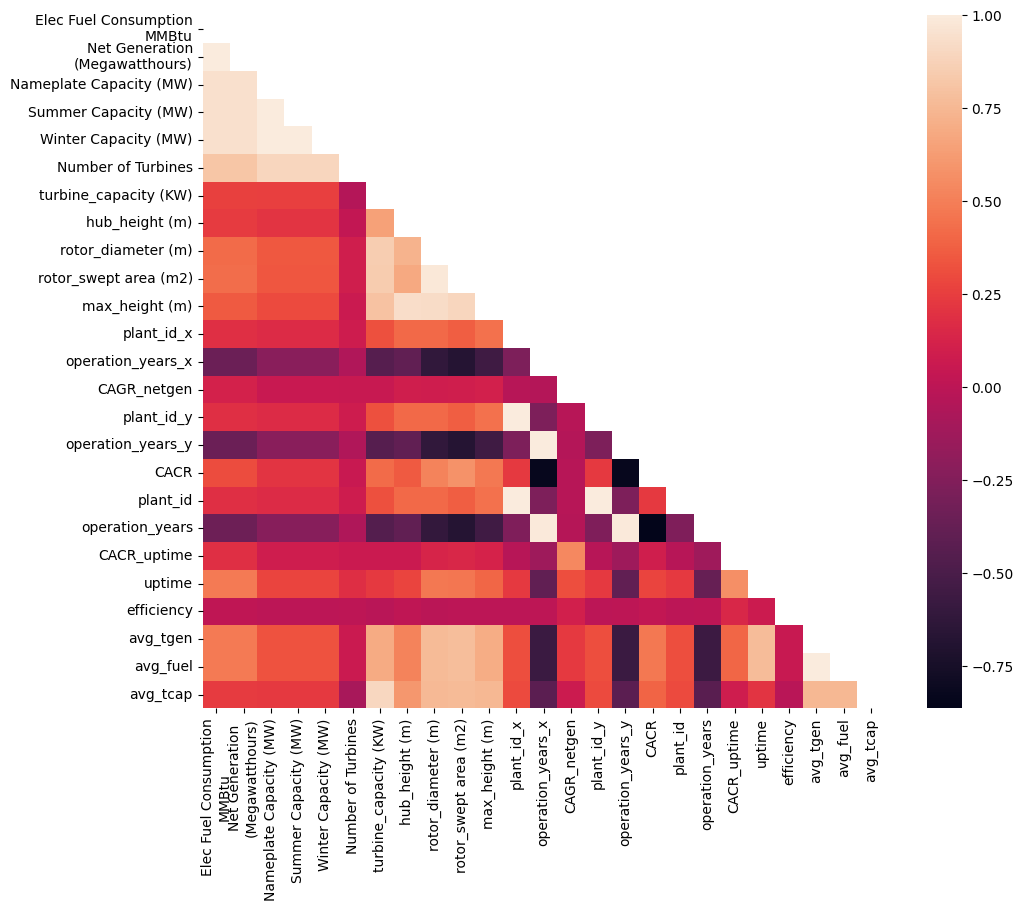

In [90]:
# remove xlong and ylat
corr_df = final_df.drop(['xlong','ylat','Plant Code','Plant Id'], axis=1)
corr = corr_df.corr(numeric_only=True)

# show only half the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask)

## Pipeline

In [91]:
models = [
        ('KM', KMeans()),
        ('AC', AgglomerativeClustering()),
        ('BIR', Birch()),
        ('MBKM', MiniBatchKMeans()),
        ('OPT', OPTICS()),
        ('SC', SpectralClustering())
        # ('MS', MeanShift()),
        # ('DB', DBSCAN()),
        # ('AP', AffinityPropagation())
        ]

In [172]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017 entries, 0 to 1016
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Plant Id                        1017 non-null   int64  
 1   Reported
Prime Mover            1017 non-null   object 
 2   Plant State                     1017 non-null   object 
 3   Census Region                   1017 non-null   object 
 4   NERC Region                     1005 non-null   object 
 5   Elec Fuel Consumption
MMBtu     1017 non-null   int64  
 6   Net Generation
(Megawatthours)  1017 non-null   float64
 7   Plant Code                      1017 non-null   int64  
 8   Sector Name                     1017 non-null   object 
 9   Utility Name                    1017 non-null   object 
 10  Nameplate Capacity (MW)         1017 non-null   float64
 11  Summer Capacity (MW)            1017 non-null   float64
 12  Winter Capacity (MW)            10

In [190]:
# drop features
dropped_features = ['xlong', 'ylat', 'Plant Id','Reported\nPrime Mover','Plant State', 'Census Region', 'NERC Region','Plant Code',
                    'Number of Turbines','turbine_capacity (KW)','Sector Name','Utility Name',
                    'plant_id_x', 'operation_years_x',
                    'plant_id_y', 'operation_years_y', 
                    'plant_id',  'operation_years',
                    # 'CAGR', 'CACR_uptime', 
                    'CAGR_netgen',
                    # 'avg_tgen','avg_fuel','avg_tcap',
                    'Net Generation\n(Megawatthours)', 'Elec Fuel Consumption\nMMBtu', 'Nameplate Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)',
                    'hub_height (m)', 'rotor_diameter (m)', 'rotor_swept area (m2)', 'max_height (m)']

In [191]:
X = final_df.drop(dropped_features, axis=1)

In [192]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017 entries, 0 to 1016
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CACR         1014 non-null   float64
 1   CACR_uptime  1017 non-null   float64
 2   uptime       1017 non-null   float64
 3   efficiency   1017 non-null   float64
 4   avg_tgen     1017 non-null   float64
 5   avg_fuel     1017 non-null   float64
 6   avg_tcap     1017 non-null   float64
dtypes: float64(7)
memory usage: 63.6 KB


In [193]:
X = X.fillna(0)

In [194]:
# setup the ordinal features
# ordinal_features = ['education']
# order = [['basic.4y', 'basic.6y','basic.9y', 'high.school','professional.course','university.degree']]

# setup the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# for idp_var in ordinal_features:
    # while idp_var in categorical_features:
        # categorical_features.remove(idp_var)

In [195]:
inertia = []
s_score = []
db_score = []
ch_score = []
clusters = [2,3,4,5,6]

preprocessor = ColumnTransformer(transformers=[
    ('tnf1',MinMaxScaler(),numerical_features),
    # ('tnf2',OrdinalEncoder(categories=order),ordinal_features),
    ('tnf3',OneHotEncoder(),categorical_features)
# ])
], remainder='passthrough')

print('intertia: lower is better, s_score: close to 1 is better, db_score: closer to 0 is better, ch_score: higher is better')

# optimize clusters for unknown data labels
for name, model in models:
    for i in clusters:
        n_model = KMeans(n_clusters = i, random_state =42)
        
        print(f'running {model} with {i} clusters')    
        pipeline = Pipeline([('preprocessor', preprocessor),
                            #  ("dimred_step", PCA(n_components=4)),
                             ('cluster', n_model)])
        pipeline.fit(X)
        inertia.append(pipeline.named_steps['cluster'].inertia_)
        print(f'for clusters = {i}, the inertia is : {pipeline.named_steps["cluster"].inertia_}')
        cluster_labels = pipeline.named_steps['cluster'].labels_

        silhouette_avg = silhouette_score(X, cluster_labels)
        s_score.append(silhouette_avg)
        print(f'for clusters = {i}, the average silhouette_score is : {silhouette_avg}')

        db = davies_bouldin_score(X, cluster_labels)
        db_score.append(db)
        print(f'for clusters = {i}, the Davies-Bouldin Index is : {db}')

        ch = calinski_harabasz_score(X, cluster_labels)
        ch_score.append(ch)
        print(f'for clusters = {i}, the Calinski-Harabasz Index is : {ch}')

        print()
        
    break

intertia: lower is better, s_score: close to 1 is better, db_score: closer to 0 is better, ch_score: higher is better
running KMeans() with 2 clusters
for clusters = 2, the inertia is : 63.667289827798996
for clusters = 2, the average silhouette_score is : 0.5144508838317923
for clusters = 2, the Davies-Bouldin Index is : 0.6438248751542859
for clusters = 2, the Calinski-Harabasz Index is : 1575.4308305690147

running KMeans() with 3 clusters
for clusters = 3, the inertia is : 47.366864824652296
for clusters = 3, the average silhouette_score is : 0.38417804475525164
for clusters = 3, the Davies-Bouldin Index is : 0.8549664696026827
for clusters = 3, the Calinski-Harabasz Index is : 1099.8027359793557

running KMeans() with 4 clusters
for clusters = 4, the inertia is : 37.407922820390894
for clusters = 4, the average silhouette_score is : 0.38567490765696133
for clusters = 4, the Davies-Bouldin Index is : 1.34283044254468
for clusters = 4, the Calinski-Harabasz Index is : 1291.854653362

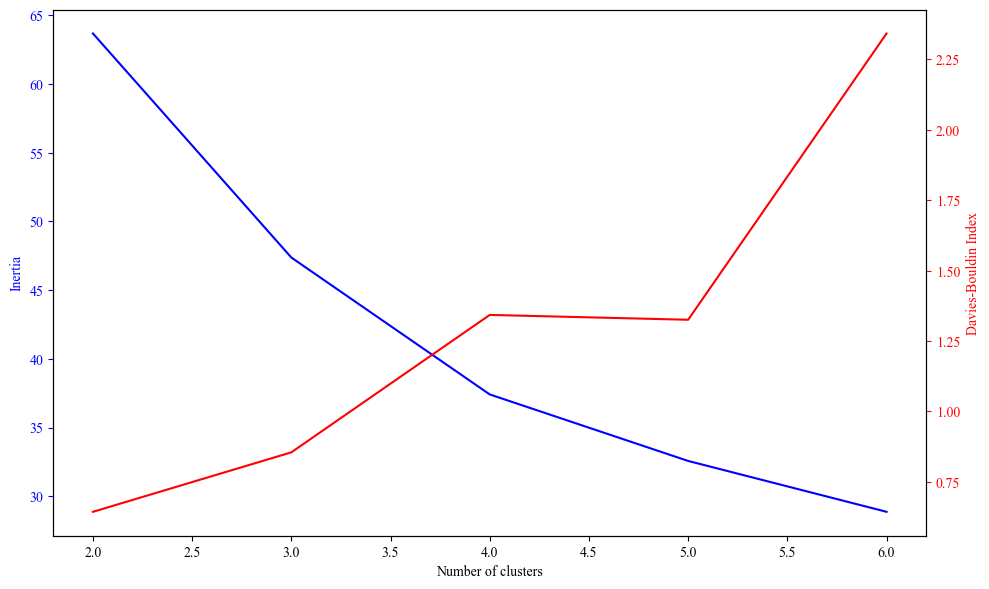

In [196]:
# lower is better
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(clusters, inertia, 'b-')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(clusters, db_score, 'r-')
ax2.set_ylabel('Davies-Bouldin Index', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()

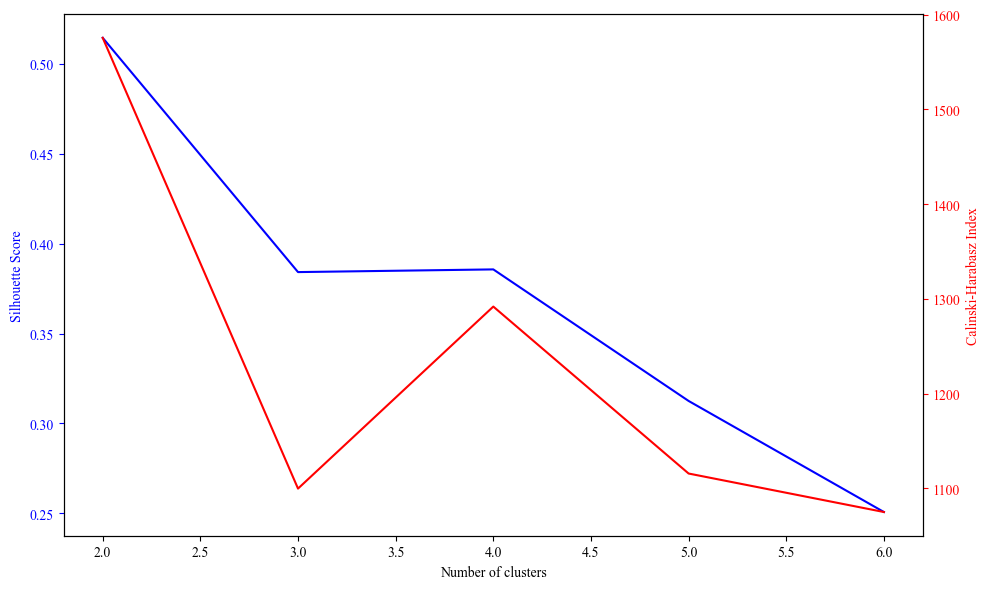

In [197]:
# higher is better
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(clusters, s_score, 'b-')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Score', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(clusters, ch_score, 'r-')
ax2.set_ylabel('Calinski-Harabasz Index', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [198]:
ideal_k= 2
n_model = KMeans(n_clusters = ideal_k, random_state =42)
          
pipeline = Pipeline([('preprocessor', preprocessor),
                    #  ("dimred_step", PCA(n_components=4)),
                        ('cluster', n_model)])
pipeline.fit(X)
cluster_labels = pipeline.named_steps['cluster'].labels_

In [199]:
final_copy = final_df.copy()

# append cluster_labels to final_df
final_copy['cluster'] = cluster_labels

In [200]:
final_copy.cluster.value_counts()

0    541
1    476
Name: cluster, dtype: int64

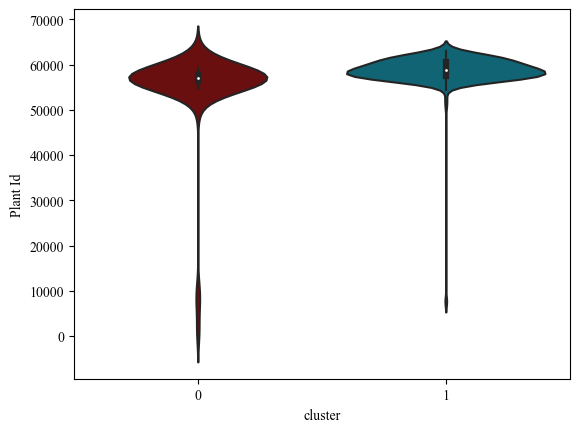

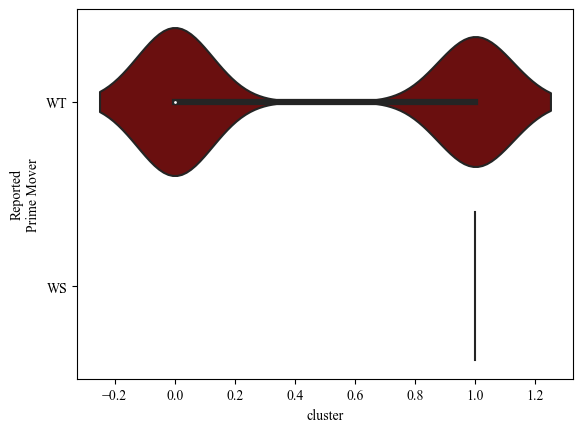

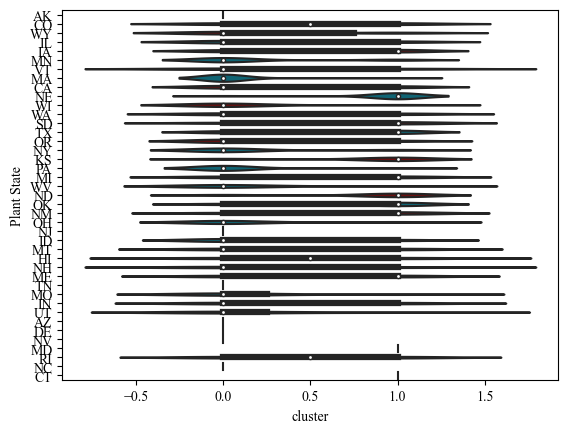

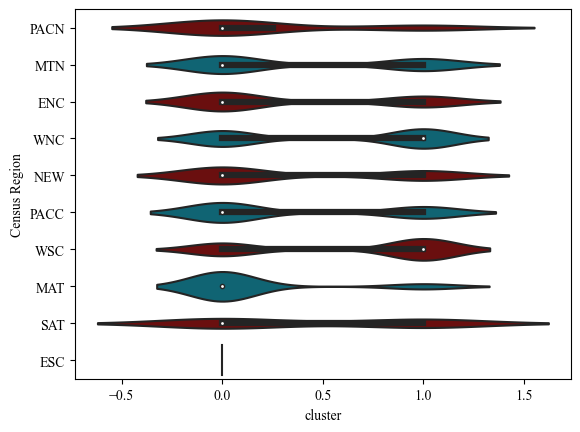

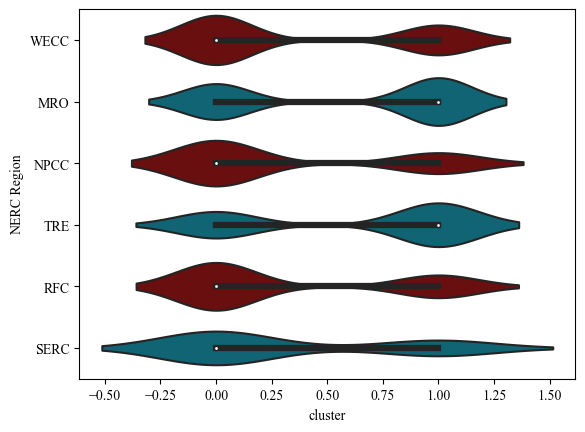

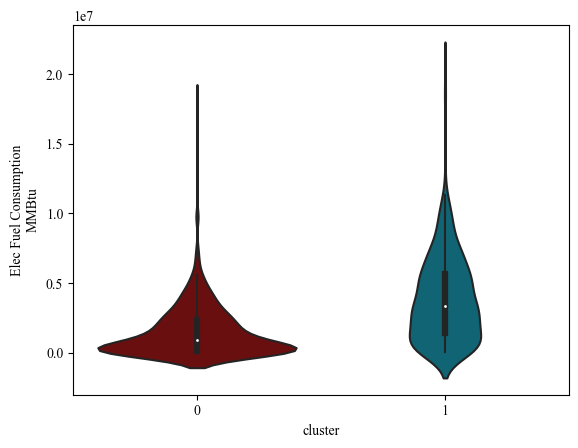

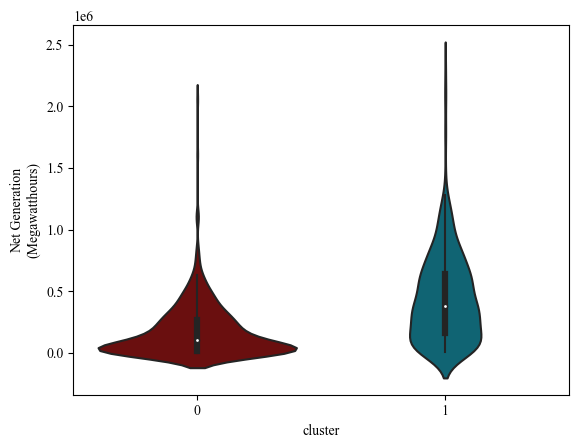

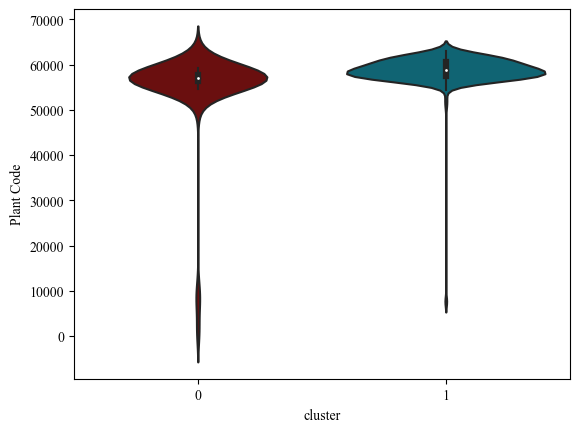

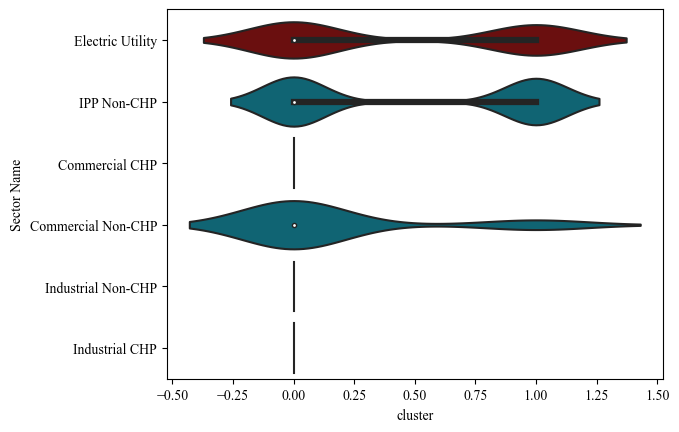

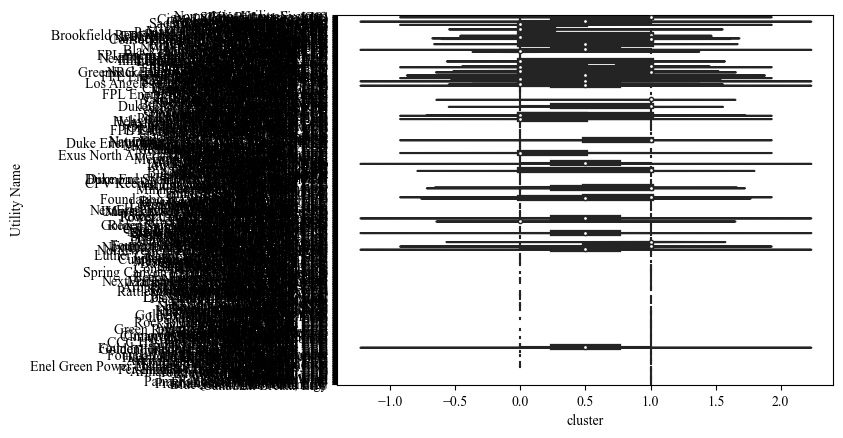

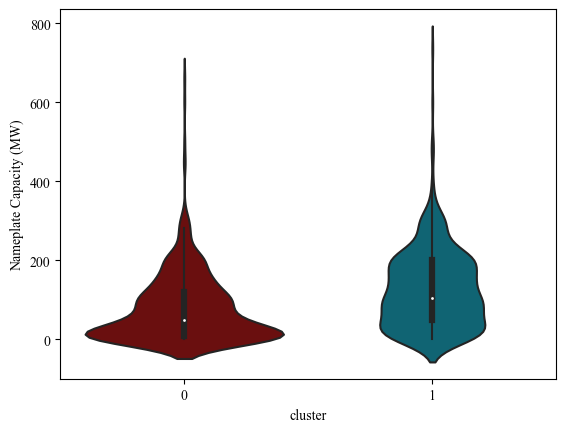

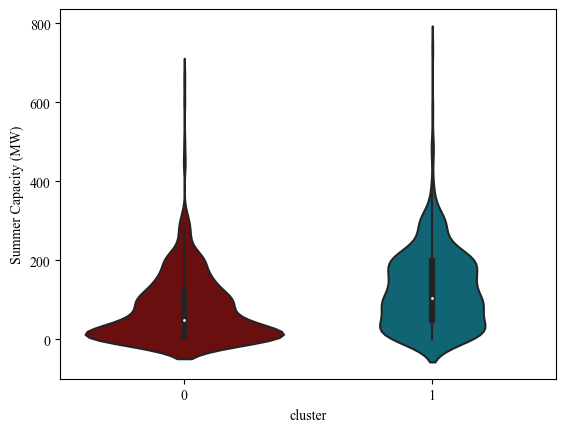

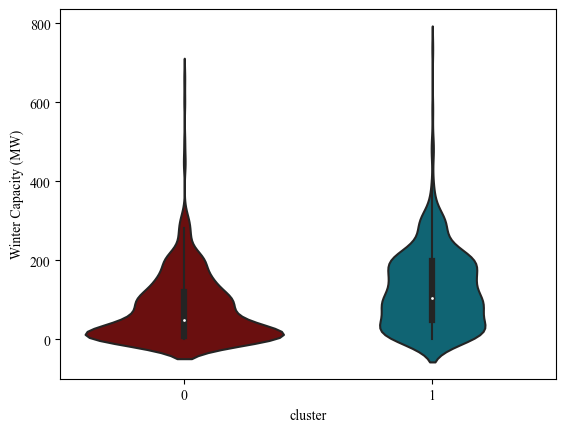

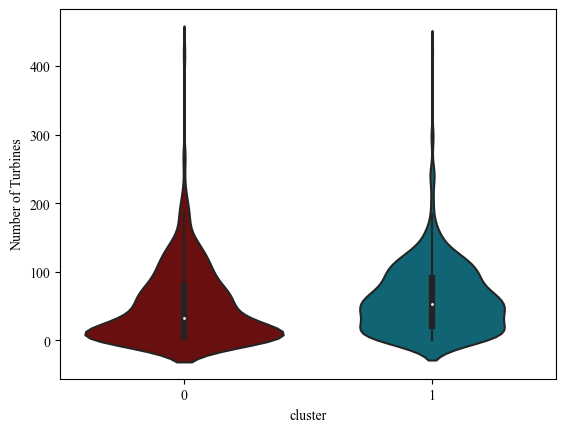

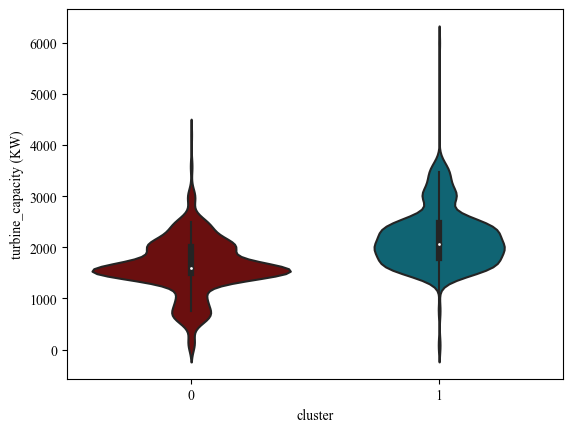

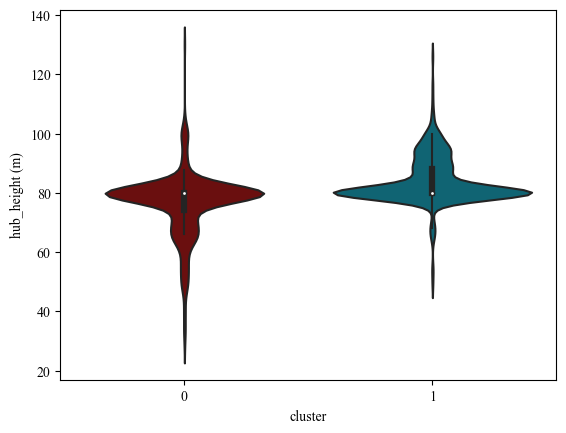

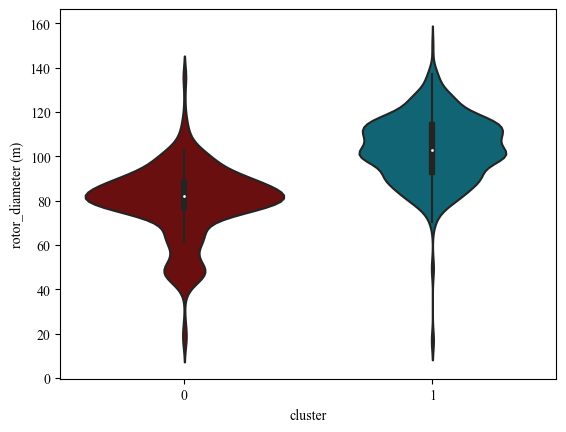

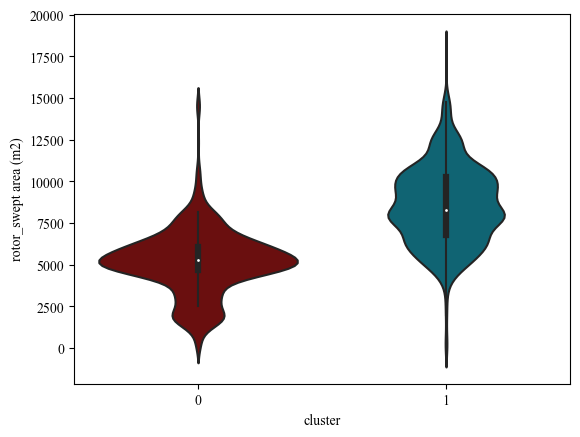

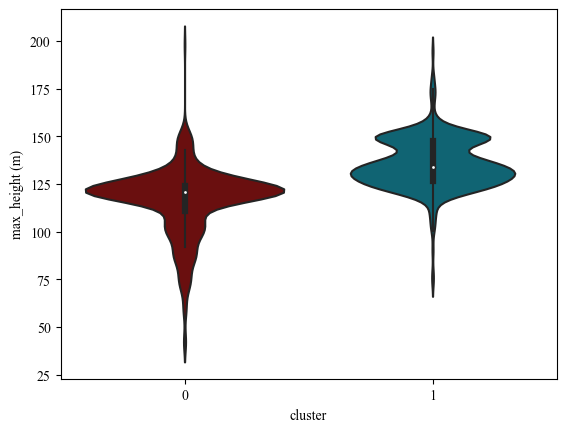

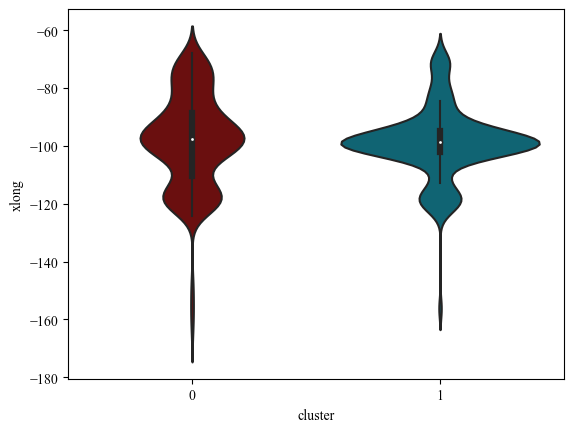

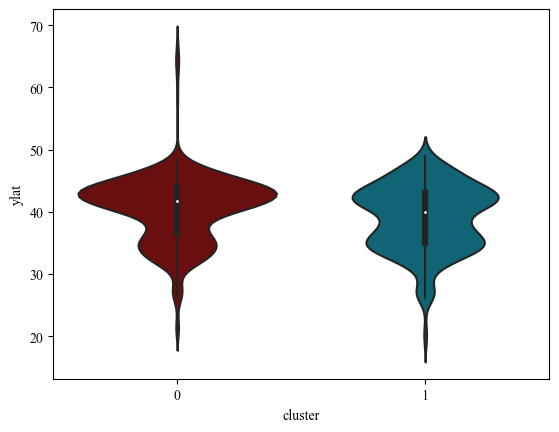

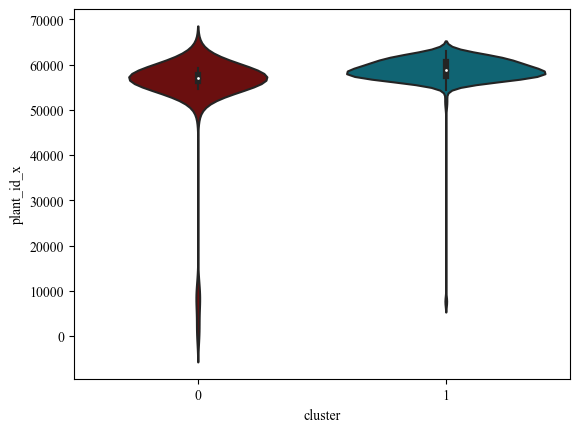

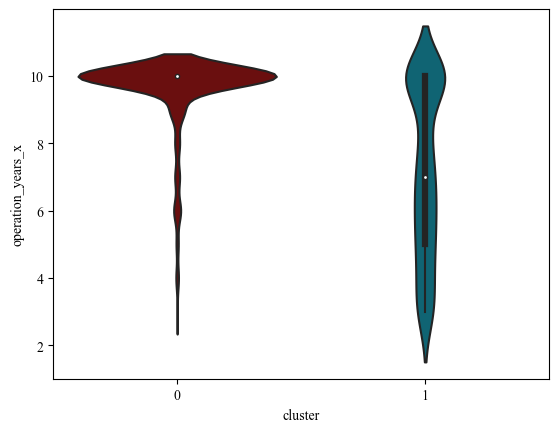

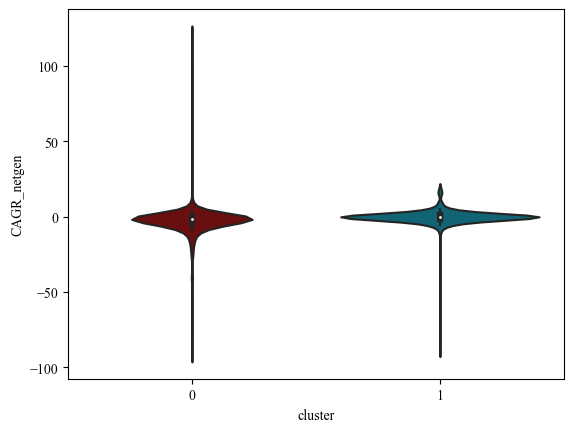

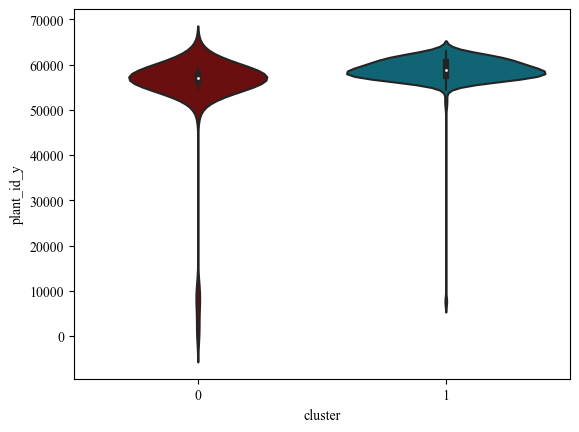

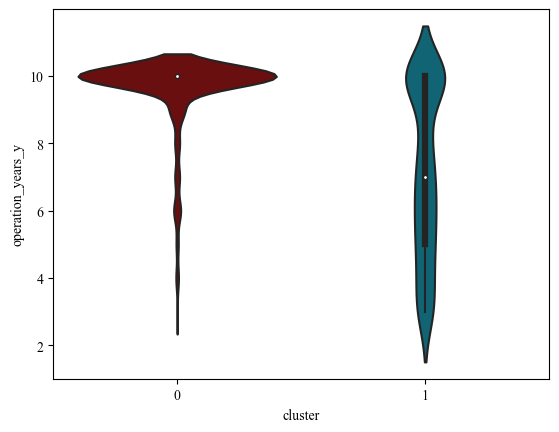

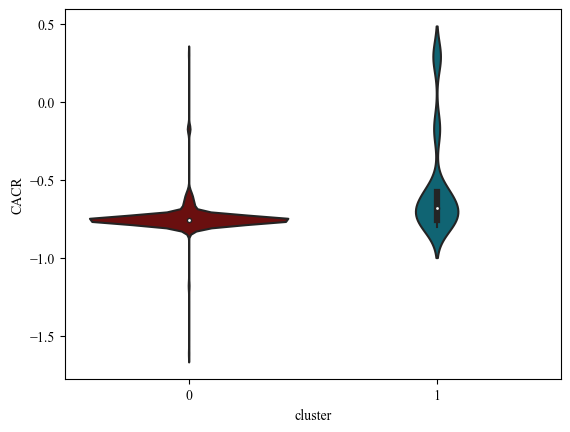

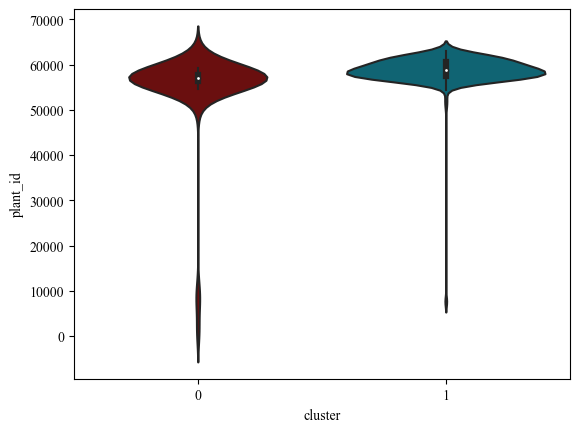

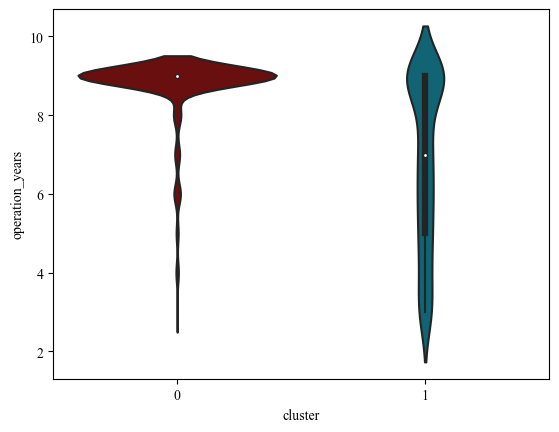

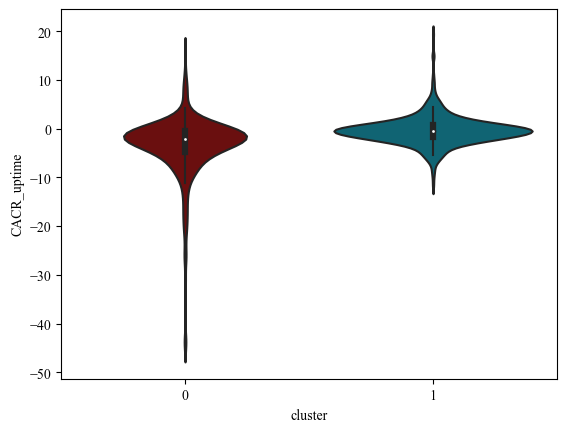

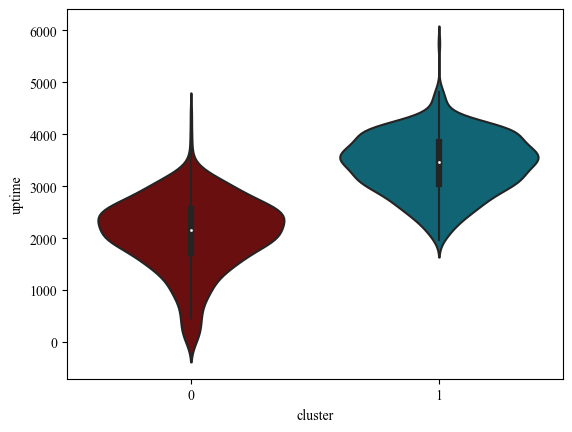

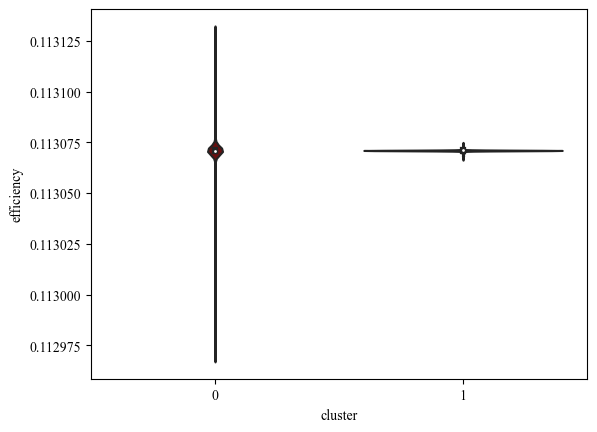

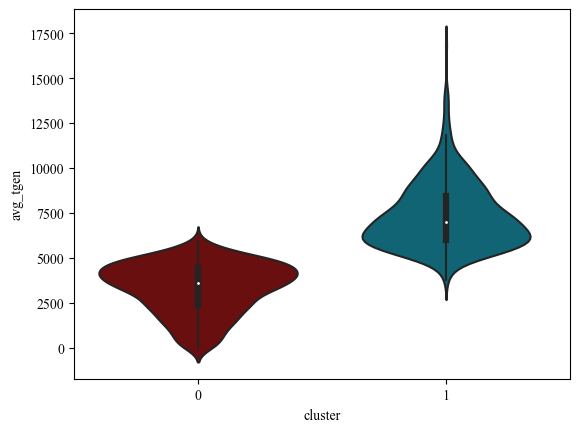

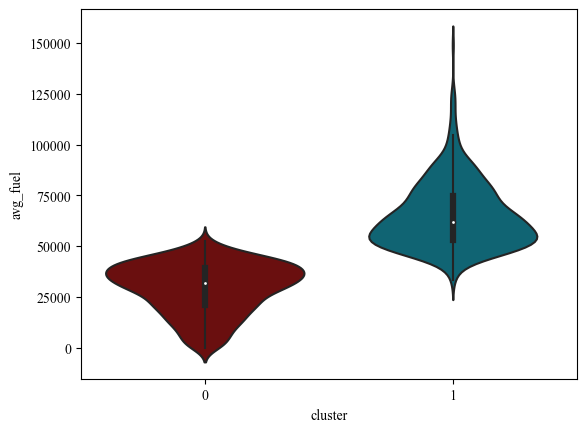

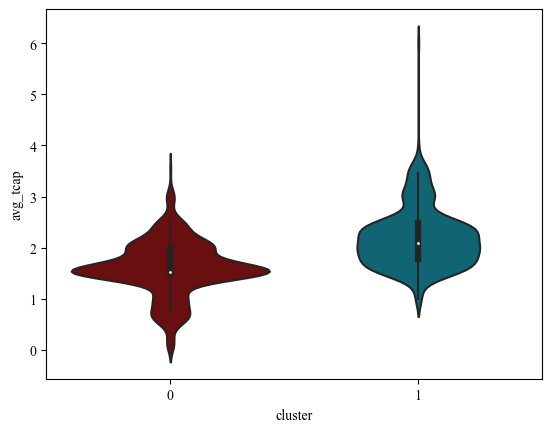

In [201]:
# show bar charts of clusters
for col in final_copy.columns:
    if col != 'cluster':
        # use #790000 for cluster 1 and #006F83 for cluster 0
        sns.violinplot(x='cluster', y=col, data=final_copy, palette=['#790000', '#006F83'])
        # change font to times new roman
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.show()

In [202]:
final_copy.to_csv('Data/final_copy.csv')

In [203]:
# plot scatter plot of lat long with cluster by color on a map
fig = px.scatter_mapbox(final_copy, lat="ylat", lon="xlong", color="cluster", zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [204]:
final_copy.describe()

,Plant Id,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),Plant Code,Nameplate Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Number of Turbines,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),xlong,ylat,plant_id_x,operation_years_x,CAGR_netgen,plant_id_y,operation_years_y,CACR,plant_id,operation_years,CACR_uptime,uptime,efficiency,avg_tgen,avg_fuel,avg_tcap,cluster
count,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1008.00,1014.00,1014.00,1008.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1014.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00,1017.00
mean,56776.74,2643843.25,298941.92,56776.74,101.03,100.70,100.70,55.49,1888.17,79.96,90.68,6769.24,125.49,-98.67,39.85,56776.74,8.47,-1.53,56776.74,8.47,-0.65,56776.74,7.84,-2.03,2715.42,0.11,5218.83,46155.32,1.88,0.47
std,8129.07,2833321.10,320366.52,8129.07,95.88,95.86,95.86,54.30,619.24,10.01,19.73,2722.03,18.22,14.48,5.42,8129.07,2.28,8.77,8129.07,2.28,0.26,8129.07,1.88,5.30,923.95,0.00,2576.55,22787.03,0.62,0.50
min,90.00,478.00,54.00,90.00,1.00,0.40,0.50,1.00,65.00,28.59,16.50,213.82,41.53,-165.43,18.97,90.00,3.00,-90.33,90.00,3.00,-1.62,90.00,3.00,-44.25,13.73,0.11,1.35,11.93,0.06,0.00
25%,56673.00,383760.00,43392.00,56673.00,20.00,20.00,20.00,10.00,1500.00,80.00,81.26,5213.28,118.60,-103.50,35.39,56673.00,7.00,-2.69,56673.00,7.00,-0.76,56673.00,7.00,-3.08,2102.48,0.11,3477.78,30757.49,1.50,0.00
50%,57474.00,1838695.00,207903.00,57474.00,80.00,80.50,80.50,44.00,1800.00,80.00,90.00,6361.73,125.00,-98.49,41.16,57474.00,10.00,-0.88,57474.00,10.00,-0.76,57474.00,9.00,-1.30,2711.79,0.11,5021.47,44409.87,1.80,0.00
75%,59005.00,3927417.00,444077.00,59005.00,151.80,151.40,151.40,84.00,2300.00,80.00,103.00,8332.29,135.00,-92.68,43.58,59005.00,10.00,0.58,59005.00,10.00,-0.65,59005.00,9.00,0.15,3420.00,0.11,6837.93,60474.64,2.30,1.00
max,63030.00,20464778.00,2313973.00,63030.00,735.50,735.50,735.50,426.00,6000.00,130.00,150.00,17671.46,198.10,-67.81,66.84,63030.00,10.00,120.49,63030.00,10.00,0.31,63030.00,9.00,19.35,5750.48,0.11,16841.60,148947.00,6.00,1.00
